# Single-Photon 3D Imaging with Equi-Depth Photon Histograms (ECCV24)

This implemetation demonstrates how to use SPCSim to reproduce some of results from the paper "Single-Photon 3D Imaging with Equi-Depth Photon Histograms" [1].

## EW histogram vs ED histogram

Figure 2 of the paper compares the EW histogram and ED histogram for the same scene distance, illumination conditions and number of histogram bins.

In [2]:
from SPCSim.data_loaders.perpixel_loaders import PerPixelLoader
from SPCSim.data_loaders.transient_loaders import TransientGenerator
from SPCSim.utils.plot_utils import plot_transient, plot_ewh, plot_edh
import matplotlib.pyplot as plt
from SPCSim.sensors.dtof import RawSPC, BaseEWHSPC, BaseEDHSPC
import torch
import numpy as np


# Simulating results for distance = 0.3*MaxDistance, for laser time period = 100ns
# for average 0.1 signal photons per laser cycle and 0.2 background photons per laser cycle
PixLdr = PerPixelLoader(
                        min_dist = 0.3,
                        tmax = 100, # in nano seconds
                        sig_bkg_list = [[0.1,0.2]],
                        device = "cpu" # Choosing to run on CPU
                        )

# Generate the per pixel data
data = PixLdr.get_data()


# Creating transient generator with laser time period of 100ns, FWHM (pulse width) 5ns and with
# laser time period divided into 1000 equal time-bins
tr_gen = TransientGenerator(Nr = PixLdr.Nr, Nc = PixLdr.Nc, N_tbins = 1000, tmax = PixLdr.tmax, FWHM = 5)


# Using the get_transient function to generate the transient
# for a given distance, albedo, intensity, and illumination condition
phi_bar = tr_gen.get_transient(data["gt_dist"],
                               data["albedo"], # By default albedo is just a array of ones
                               data["albedo"],
                               data["alpha_sig"],
                               data["alpha_bkg"])

Nr, Nc, N_tbins = phi_bar.shape
device = PixLdr.device
seed_val = 43

# Simulating data for 500 laser cycles
N_pulses = 100

# Setting RawSPC to return 500 timestamps per pixel over the total exposure time.
# As RawSPC simulates single photon timestamp per laser cycle
N_output_ts = N_pulses

The `RawSPC` is used to simulate the photon time-stamps, `BaseEWHSPC` is used to capture corresponding equi-width histogram, and `BaseEDHSPC` class is used to capture the equi-depth histogram.

`NOTE: Using the same non-zero seed value we can reproduce the poisson randomness in the photon timestamps.`

In [3]:
spc1 = RawSPC(Nr,
              Nc,
              N_pulses,
              device,
              N_tbins,
              N_output_ts,
              seed=seed_val)

# Captured data contains timestamps (Nr x Nc x N_output_ts)
captured_data1 = spc1.capture(phi_bar)

# Accessing the timestamp data
raw_data = captured_data1["time_stamps"]


# Simulating data for 8-bin BaseEWHSPC sensor
N_ewhbins = 8
spc2 = BaseEWHSPC(
                Nr,
                Nc,
                N_pulses,
                device,
                N_tbins,
                N_ewhbins,
                seed=seed_val
               )

# Captured data contains equi-width histogram (Nr x Nc x N_ewhbins)
captured_data2 = spc2.capture(phi_bar)

# Accessing the equi-width histogram
ewh_data = captured_data2["ewh"]

# Simulating data for 8-bin BaseEDHSPC sensor
N_edhbins = N_ewhbins
spc3 = BaseEDHSPC(Nr,
              Nc,
              N_pulses,
              device,
              N_tbins,
              N_edhbins,
              seed=seed_val)

# Captured data contains equi-depth histogram (Nr x Nc x N_ewhbins)
captured_data3 = spc3.capture(phi_bar)

# Accessing the equi-depth histogram
oedh_data = captured_data3["oedh"]

100%|██████████| 100/100 [00:00<00:00, 9763.50it/s]


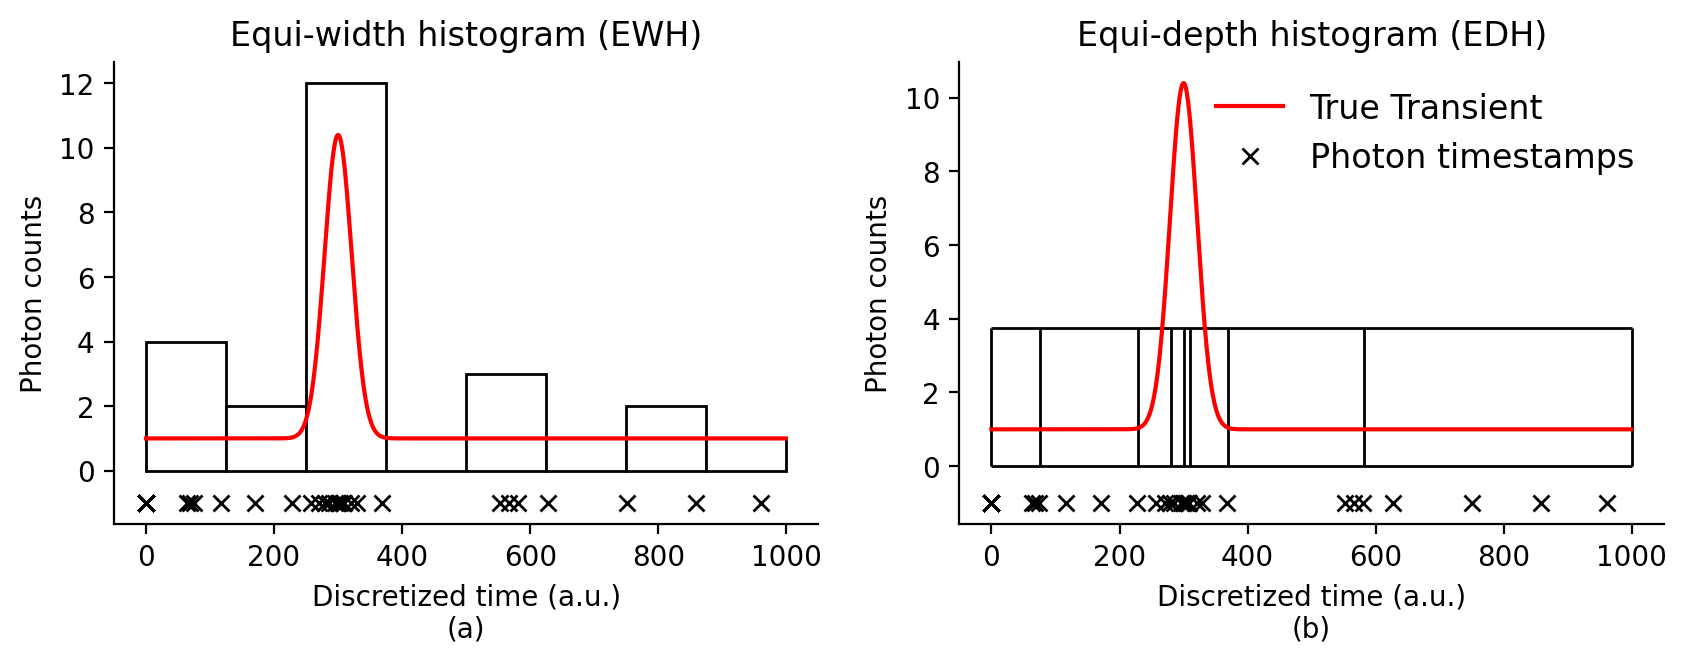

In [4]:
# Plotting the results
ROW, COL = [0,0]

phi_bar1 = phi_bar[ROW, COL, :].cpu().numpy()
ts = raw_data[ROW, COL, :].cpu().numpy().flatten()
ewh1 = ewh_data[ROW, COL, :].cpu().numpy()
edh1 = oedh_data[ROW, COL, :].cpu().numpy()

ewh_bins_axis = torch.linspace(0,N_tbins-N_tbins//N_ewhbins,N_ewhbins)
EDH_Height = (((data["alpha_sig"][ROW,COL]+data["alpha_bkg"][ROW,COL])*N_pulses/N_edhbins))


fig1, (ax1, ax2) = plt.subplots(1,2,figsize = (10,3))
plot_ewh(ax1, ewh_bins_axis, ewh1, label = "EWH histogram", color = 'w')
plot_transient(ax1, phi_bar1*50*spc1.N_pulses, plt_type = '-r', label="True Transient")
ax1.plot(ts, np.random.rand(ts.shape[-1])*0.001-1,'xk', label='Photon timestamps', linewidth=1)
csfont = {'fontname':'Times New Roman'}
ax1.set_title("Equi-width histogram (EWH)")
ax1.set_xlabel("Discretized time (a.u.)\n(a)")
ax1.set_ylabel("Photon counts")
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

ax2.set_title("Equi-depth histogram (EDH)")
# ax2.bar(edh1[:-1], EDH_Height, width = edh_widths,color='w', alpha=0.5, edgecolor = 'black', align = 'edge', linewidth=1)
plot_edh(edh1,ax2,ymax = EDH_Height, colors_list=['k','k','k','k','k','k'])
plot_transient(ax2, phi_bar1*50*spc1.N_pulses, plt_type = '-r', label="True Transient")
ax2.plot(ts, np.random.rand(ts.shape[-1])*0.001-1,'xk', label='Photon timestamps', linewidth=1)
ax2.legend(frameon=False,fontsize="12",loc='upper right')
# ax2.set_ylim(top = EWH.max()*1.2)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.set_xlabel("Discretized time (a.u.)\n(b)")
ax2.set_ylabel("Photon counts")
plt.gcf().set_dpi(200)
# plt.tight_layout()
fig1.savefig("Temp_Fig2.png")

## Comparing binner stepping strategies

We can use SPCSim to reproduce Figure 3 in the paper to compare the fixed stepping and optimized stepping binners.

2000


100%|██████████| 2000/2000 [00:00<00:00, 2110.01it/s]


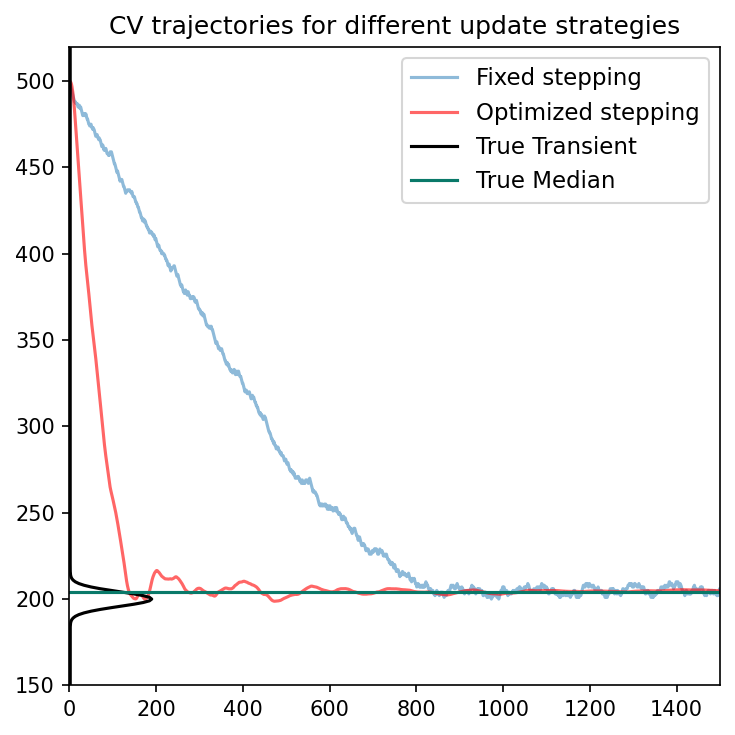

In [5]:
from SPCSim.utils.plot_utils import plot_transient, plot_edh, plot_edh_traj
from SPCSim.sensors.dtof import HEDHBaseClass, PEDHOptimized
from SPCSim.postproc.edh_postproc import PostProcEDH


N_edhbins = 2 # Number of EDH bins
N_pulses = 2000 # Number of laser pulses
N_tbins = 1000 # Number of time bins per laser cycle (B)
FWHM = 1 # in nano seconds
device = "cpu" # Select the CPU/GPU device
seed_val = 43

# Simulating results for distance = 0.2*MaxDistance, for laser time period = 100ns
# for average 1 signal photons per laser cycle and 1 background photons per laser cycle
PixLdr = PerPixelLoader(
                        min_dist = 0.2,
                        tmax = 100, # in nano seconds
                        sig_bkg_list = [[1,1]],
                        device = "cpu" # Choosing to run on CPU
                        )

# Generate the per pixel data
data = PixLdr.get_data()


# Creating transient generator with laser time period of tmax ns, FWHM and with
# laser time period divided into N_tbins equal time-bins
tr_gen = TransientGenerator(Nr = PixLdr.Nr, Nc = PixLdr.Nc, N_tbins = N_tbins, tmax = PixLdr.tmax, FWHM = FWHM)


# Using the get function to generate the transient
# for a given distance, albedo, intensity, and illumination condition
phi_bar = tr_gen.get_transient(data["gt_dist"], # NOTE: the true distance is in meters and depends on tmax
                               data["albedo"],
                               data["albedo"],
                               data["alpha_sig"],
                               data["alpha_bkg"])

# Set row and column of the pixel for which you want to track the CV trajectories
ROW, COL = [0,0]

# Initializing the HEDHBaseClass with desired sensor parameters
spc1 = HEDHBaseClass(PixLdr.Nr,
              PixLdr.Nc,
              N_pulses,
              device,
              N_tbins,
              N_edhbins,
              pix_r = ROW,
              pix_c = COL,
              seed=seed_val,
              step_params={
                  "k":1, # Step size gain
                  "step_vals": [1], # List of reducing step size values per binner
              })

# Capture method runs the HEDH binners for N_pulses based on the input true transient (phi_bar)
captured_data1 = spc1.capture(phi_bar)

# Extracting desired data components
edh_data1 = captured_data1["edh"].cpu().numpy() # Contains the binner output for selected EDH class
gtedh_data1 = captured_data1["gtedh"].cpu().numpy() # Contains the ground truth EDH computed using the true transient
edh_list1 = captured_data1["traj"] # Contains the binner trajectories for pixel at location
edh_list1 = np.array(edh_list1)


# Initializing the PEDHOptimized with desired sensor parameters and stepping params
spc2 = PEDHOptimized(PixLdr.Nr,
              PixLdr.Nc,
              N_pulses,
              device,
              N_tbins,
              N_edhbins,
              pix_r = ROW,
              pix_c = COL,
              seed = seed_val,
              step_params={
                  "k":3, # Step size gain
                  "decay":0, # Setting decay = 0 allows to update final decay value as a function of N_pulses
                  "mtm":0.8,
                  "min_clip":0.02,
                  "switch_fraction":0.8,
                  "delta_mem": 0.95
              })

# Capture method runs the HEDH binners for N_pulses based on the input true transient (phi_bar)
captured_data2 = spc2.capture(phi_bar)

# Extracting desired data components
edh_data2 = captured_data2["edh"].cpu().numpy() # Contains the binner output for selected EDH class
gtedh_data2 = captured_data2["gtedh"].cpu().numpy() # Contains the ground truth EDH computed using the true transient
edh_list2 = captured_data2["traj"] # Contains the binner trajectories for pixel at location
edh_list2 = np.array(edh_list2)
phi_bar = phi_bar[0,0,:].cpu().numpy()

ewh_bins_axis = torch.linspace(0,N_tbins-1,N_tbins)

fig1, ax1 = plt.subplots(1,1, figsize=(5,5))
ax1.set_title(r'CV trajectories for different update strategies')
ax1.plot(edh_list1, label="Fixed stepping", alpha=0.5)
ax1.plot(edh_list2,'-r',label="Optimized stepping", alpha=0.6)
ax1.plot(phi_bar*N_pulses,ewh_bins_axis, '-k', label="True Transient")
ax1.axhline(gtedh_data2[0,0,1], color = '#097969', label = "True Median")
ax1.set_xlim(left = -0.5)
ax1.set_xlim(left = 0, right = 1500)
ax1.set_ylim(top = 520, bottom = 150)
ax1.legend(fontsize="11")
plt.gcf().set_dpi(150)
plt.tight_layout()
fig1.savefig("Temp_Fig3.png")


## Post processing ED histograms

The `edh_postproc` module of `postproc` subpackage provides `PostProcEDH` class to compute the photon density estimates and piecewise-constant $\rho_0$ and piecewise-linear ($\rho_1$) interpolated photon desntity estimates.

100%|██████████| 5000/5000 [00:25<00:00, 194.60it/s]


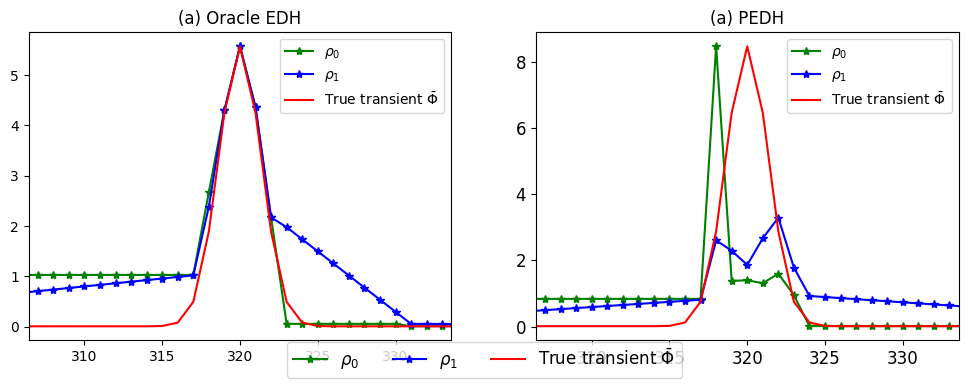

In [6]:
from SPCSim.data_loaders.perpixel_loaders import PerPixelLoader
from SPCSim.data_loaders.transient_loaders import TransientGenerator
import matplotlib.pyplot as plt
from SPCSim.sensors.dtof import BaseEDHSPC, PEDHOptimized
from SPCSim.postproc.edh_postproc import PostProcEDH
import time
import torch
import numpy as np
from SPCSim.utils.plot_utils import plot_transient, plot_edh


seed_val = 43

# Simulating results for distance = 0.1*dmax
PixLdr = PerPixelLoader(min_dist = 0.32,
                        tmax = 100,
                        sig_bkg_list = [
                            [2,1]],
                        device = "cpu")

# Generate the per pixel data
data = PixLdr.get_data()


# Creating transient generator with laser time period of 100ns, FWHM 1 and with
# laser time period divided into 1000 equal time-bins
tr_gen = TransientGenerator(N_tbins = 1000, tmax = PixLdr.tmax, FWHM = 0.32)


# Using the get function to generate the transient
# for a given distance, albedo, intensity, and illumination condition
phi_bar = tr_gen.get_transient(data["gt_dist"],
                               data["albedo"],
                               data["albedo"],
                               data["alpha_sig"],
                               data["alpha_bkg"])


# Setting the dimensions, device, number of EWH bins per pixel
# and number of laser pulses

Nr, Nc, N_tbins = phi_bar.shape
device = PixLdr.device
N_edhbins = 32
N_pulses = 5000

# Set row and column of the pixel for which you want to track the CV trajectories
ROW, COL = [0,0]

spc1 = PEDHOptimized(PixLdr.Nr,
              PixLdr.Nc,
              N_pulses,
              device,
              N_tbins,
              N_edhbins,
              pix_r = ROW,
              pix_c = COL,
              seed = seed_val,
              step_params={
                  "k":3, # Step size gain
                  "decay":0, # Setting decay = 0 allows to update final decay value as a function of N_pulses
                  "mtm":0.8,
                  "min_clip":0.02,
                  "switch_fraction":0.8,
                  "delta_mem": 0.95
              })


postproc = PostProcEDH(Nr, Nc, N_tbins, PixLdr.tmax, PixLdr.device)

captured_data = spc1.capture(phi_bar)
edh_data = captured_data["edh"]

oedh_data = captured_data["oedh"]

ewh_data = captured_data["ewh"]

oedh_rho0, _, _, oedh_pred_depth0 = postproc.edh2depth_t(oedh_data[:,:,1:-1], mode=0)
oedh_rho1, _, _, oedh_pred_depth1 = postproc.edh2depth_t(oedh_data[:,:,1:-1], mode=1)
oedh_bin_w_inv_, oedh_bin_idx_, _, oedh_pred_depth = postproc.edh2depth_t(oedh_data[:,:,1:-1], mode=2)

edh_rho0, _, _, edh_pred_depth0 = postproc.edh2depth_t(edh_data[:,:,1:-1], mode=0)
edh_rho1, _, _, edh_pred_depth1 = postproc.edh2depth_t(edh_data[:,:,1:-1], mode=1)
edh_bin_w_inv_, edh_bin_idx_, _, edh_pred_depth = postproc.edh2depth_t(edh_data[:,:,1:-1], mode=2)


fig, (ax, ax2) = plt.subplots(1,2, figsize=(12,4))


ymax = ((torch.sum(ewh_data[ROW,COL,:])/N_edhbins)).item()


sig, bkg = [data["alpha_sig"][ROW,COL].item(), data["alpha_bkg"][ROW, COL].item()]

edh_rho0_pix = edh_rho0[ROW, COL, :].cpu().numpy()
edh_rho1_pix = edh_rho1[ROW, COL, :].cpu().numpy()
edh_bin_w_inv_ = edh_bin_w_inv_[ROW, COL, :].cpu().numpy()
edh_bin_idx_ = edh_bin_idx_[ROW, COL, :].cpu().numpy()

oedh_rho0_pix = oedh_rho0[ROW, COL, :].cpu().numpy()
oedh_rho1_pix = oedh_rho1[ROW, COL, :].cpu().numpy()
oedh_bin_w_inv_ = oedh_bin_w_inv_[ROW, COL, :].cpu().numpy()
oedh_bin_idx_ = oedh_bin_idx_[ROW, COL, :].cpu().numpy()

tr1 = phi_bar[ROW, COL,:].cpu().numpy()
ax.set_title("(a) Oracle EDH")
plot_transient(ax, oedh_rho0_pix, label=r'$\rho_0$', plt_type='*-g')
plot_transient(ax, oedh_rho1_pix, label=r'$\rho_1$', plt_type='*-b')
plot_transient(ax, tr1*oedh_rho0_pix.max()/tr1.max(), label = r'True transient $\bar\Phi$', plt_type='-r')
# ax.step(oedh_bin_idx_,oedh_bin_w_inv_,"o:r", where="pre", label="True data points (step plot used in paper)")
ax.legend()
ax.set_xlim(left= max(np.argmax(tr1) - 10*tr_gen.smooth_sigma, 0), right = min(np.argmax(tr1) + 10*tr_gen.smooth_sigma, N_tbins))

ax2.set_title("(a) PEDH")
plot_transient(ax2, edh_rho0_pix, label=r'$\rho_0$', plt_type='*-g')
plot_transient(ax2, edh_rho1_pix, label=r'$\rho_1$', plt_type='*-b')
plot_transient(ax2, tr1*edh_rho0_pix.max()/tr1.max(), label = r'True transient $\bar\Phi$', plt_type='-r')
# ax.step(edh_bin_idx_,edh_bin_w_inv_,"o:r", where="pre", label="True data points (step plot used in paper)")
ax2.legend()

ax2.set_xlim(left= max(np.argmax(tr1) - 10*tr_gen.smooth_sigma, 0), right = min(np.argmax(tr1) + 10*tr_gen.smooth_sigma, N_tbins))

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=3, fontsize="12")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
fig.savefig("Temp_Fig4.png")


## Inference on the DeePEDH pipeline

This code block uses SPCSim to generate the photon density estimates $\rho_1$ to be passed to DeePEDH pipeline for inference. We can generate distance estimates similar to Figure 5. in the paper [1].

For the DeePEDH pipeline we use the DeepBoosting model proposed by Peng et. al,[2] and train it on our PEDH measurements simulated the the NYUv2 dataset.

100%|██████████| 5000/5000 [12:28<00:00,  6.68it/s]


(64, 64, 3)
(64, 64)


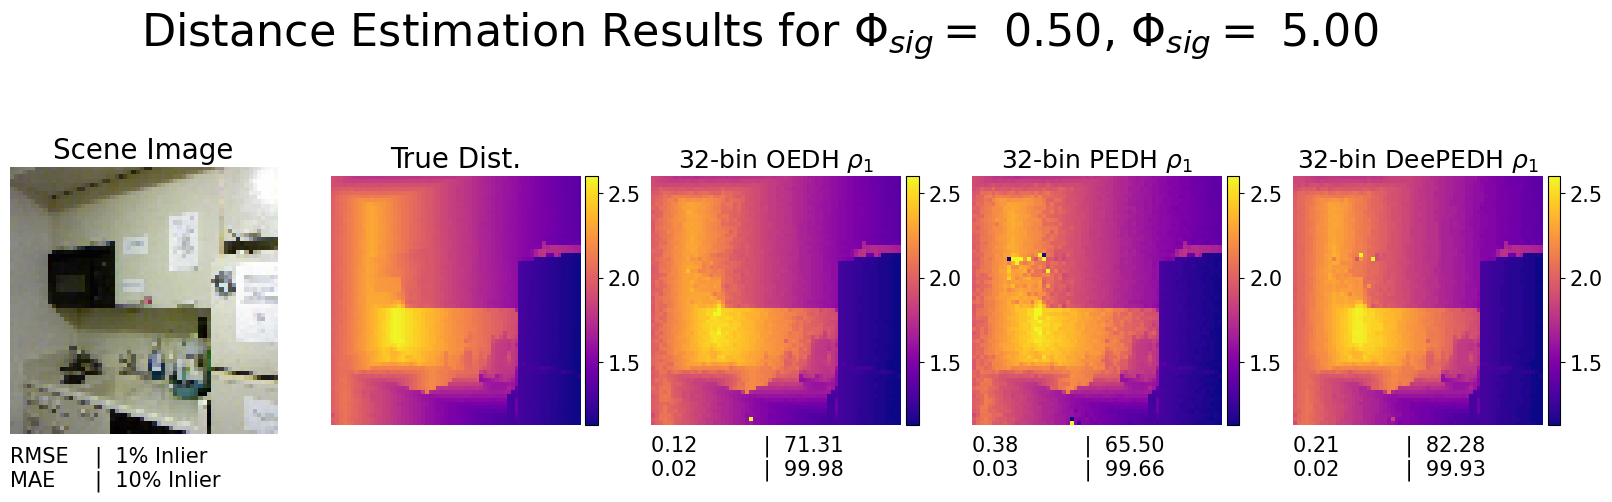

In [ ]:
from SPCSim.data_loaders.rgbd_loaders import NYULoader1
import torch
from torchvision.transforms import ToTensor
from torch.autograd import Variable
import numpy as np
import pandas as pd
from mpl_toolkits.axes_grid1 import make_axes_locatable
from SPCSim.postproc.metric import rmse, ame, p_inlier


Nr, Nc = [64,64]
N_tbins = 1024
tmax = 100
FWHM = 0.317925
device = "cuda"
N_pulses = 5000
N_edhbins = 32
seed_val = 43
alpha_sig = 0.5
alpha_bkg = 5.0

transform = ToTensor()

# Set the image resolution for the RGB-D frames
nyu_data = NYULoader1(Nr, Nc, folder="test")

# Modify the file paths as per requirement
MODEL_PATH = "Examples/DeePEDH_SingleBounce_Final.zip"
rgb_pth = "images/00001_colors.png"
dist_pth ="images/00001_depth.png"

# Access an RGB-D frame using the get_data method
data = nyu_data.get_data(rgb_pth, dist_pth, rgb_pth, rgb_pth)

# Creating transient generator with laser time period of tmax ns, FWHM and with
# laser time period divided into N_tbins equal time-bins
tr_gen = TransientGenerator(Nr = Nr, Nc = Nc, N_tbins = N_tbins, tmax = tmax, FWHM = FWHM)

# Using the get function to generate the transient
# for a given distance, albedo, intensity, and illumination condition
phi_bar = tr_gen.get_transient(data["gt_dist"], # NOTE: the true distance is in meters and depends on tmax
                               data["albedo"]*1.0/255.0,
                               data["albedo"]*1.0/255.0,
                               torch.tensor(alpha_sig),
                               torch.tensor(alpha_bkg))

# Set row and column of the pixel for which you want to track the CV trajectories
ROW, COL = [0,0]

# Initializing the HEDHBaseClass with desired sensor parameters
spc1 = PEDHOptimized(Nr,
              Nc,
              N_pulses,
              device,
              N_tbins,
              N_edhbins,
              pix_r = ROW,
              pix_c = COL,
              seed = seed_val,
              step_params={
                  "k":3, # Step size gain
                  "decay":0, # Setting decay = 0 allows to update final decay value as a function of N_pulses
                  "mtm":0.8,
                  "min_clip":0.02,
                  "switch_fraction":0.8,
                  "delta_mem": 0.95
              })

# Capture method runs the HEDH binners for N_pulses based on the input true transient (phi_bar)
captured_data1 = spc1.capture(phi_bar)

# Creating class to compute distance estimates and photon density estimates from EDH
postproc = PostProcEDH(Nr, Nc, N_tbins, tmax, device)


pedh_data = captured_data1["edh"]
# print(pedh_data.shape, pedh_data)

oedh_data = captured_data1["oedh"]
# print(oedh_data.shape, oedh_data)


pedh_rho0, _, _, pedh_pred_depth0 = postproc.edh2depth_t(pedh_data[:,:,1:-1], mode=0)
pedh_rho1, _, _, pedh_pred_depth1 = postproc.edh2depth_t(pedh_data[:,:,1:-1], mode=1)
pedh_bin_w_inv_, pedh_bin_idx_, _, pedh_pred_depth = postproc.edh2depth_t(pedh_data[:,:,1:-1], mode=2)


oedh_rho0, _, _, oedh_pred_depth0 = postproc.edh2depth_t(oedh_data[:,:,1:-1], mode=0)
oedh_rho1, _, _, oedh_pred_depth1 = postproc.edh2depth_t(oedh_data[:,:,1:-1], mode=1)
oedh_bin_w_inv_, oedh_bin_idx_, _, oedh_pred_depth = postproc.edh2depth_t(oedh_data[:,:,1:-1], mode=2)


bin_w_inv = pedh_rho1.cpu().numpy()
bin_w_inv = bin_w_inv/(bin_w_inv.mean()+0.000000001)
x = transform(bin_w_inv.copy())
x = Variable(x).unsqueeze(0).unsqueeze(0).to(device).float()

# model_scripted = torch.jit.trace(model, x) # Export to TorchScript
# torch.jit.save(model_scripted, 'DeePEDH_SingleBounce_Final.zip') # Save
model = torch.jit.load(MODEL_PATH)
model = model.to(device)
model = model.eval()

pred_depth_idx, _ = model(x)
deepedh_pred_depth = pred_depth_idx*15.0
deepedh_pred_depth = deepedh_pred_depth.view(Nr, Nc).detach()


#####################################
######### Plotting Results ##########

fig, ax = plt.subplots(1,5, figsize=(20,6))
font_s = 15
font_t = 18
alpha1 = 1
alpha2 = 10

rgb_img = data["rgb"].cpu().numpy()
gt_dist = data["gt_dist"].cpu().numpy()

print(rgb_img.shape)
print(gt_dist.shape)

ax[0].set_title("Scene Image", fontsize=font_t+2)
ax[0].imshow(rgb_img)
ax[0].axis('off')

temp_txt = "RMSE    |  %d%% Inlier\nMAE      |  %d%% Inlier  "%(
      alpha1,
      alpha2)
ax[0].text(0.0,-0.13, temp_txt,
    horizontalalignment = 'left',
    verticalalignment = 'center',
    rotation = 'horizontal',
    fontsize = font_s,
    transform = ax[0].transAxes)

ax[1].set_title("True Dist.", fontsize=font_t+2)
im = ax[1].imshow(gt_dist, cmap="plasma")
divider = make_axes_locatable(ax[1])
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im, cax=cax)
cbar.ax.tick_params(labelsize=font_s)
ax[1].axis('off')

for plot_idx in [2,3,4]:

    if plot_idx == 2:
        method_name = r'%d-bin OEDH $\rho_1$'%N_edhbins
        pred_depth = oedh_pred_depth1.cpu().numpy()
    elif plot_idx == 3:
        method_name = r'%d-bin PEDH $\rho_1$'%N_edhbins
        pred_depth = pedh_pred_depth1.cpu().numpy()
    elif plot_idx == 4:
        method_name = r'%d-bin DeePEDH $\rho_1$'%N_edhbins
        pred_depth = deepedh_pred_depth.cpu().numpy()


    ax[plot_idx].set_title(method_name, fontsize=font_t)
    # Clipping the output to ensure better comparision
    # ax[2].imshow(np.clip(pred_depth, depth.min(), depth.max()))
    im = ax[plot_idx].imshow(np.clip(pred_depth, gt_dist.min(), gt_dist.max()), cmap="plasma")
    ax[plot_idx].axis('off')
    divider = make_axes_locatable(ax[plot_idx])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(im, cax=cax)
    cbar.ax.tick_params(labelsize=font_s)


    rmse_img, rmse_val = rmse(pred_depth, gt_dist)
    mae_img, mae_val = ame(pred_depth, gt_dist)
    pinl_mask1, pinl1 = p_inlier(pred_depth, gt_dist, alpha1)
    pinl_mask2, pinl2 = p_inlier(pred_depth, gt_dist, alpha2)

    temp_txt = "%.2f          |  %.2f  \n%.2f          |  %.2f"%(
        rmse_val,
        pinl1,
        mae_val,
        pinl2)
    ax[plot_idx].text(0.0,-0.13, temp_txt,
        horizontalalignment = 'left',
        verticalalignment = 'center',
        rotation = 'horizontal',
        fontsize = font_s,
        transform = ax[plot_idx].transAxes)
plt.suptitle(r'Distance Estimation Results for $\Phi_{sig} =$ %.2f, $\Phi_{sig} =$ %.2f'%(alpha_sig, alpha_bkg), fontsize = 32)
plt.show()
fig.savefig("DeePEDH_NYU_Result.png")


## References

----

[1] Sadekar, K., Maier, D., & Ingle, A. (2025). Single-Photon 3D Imaging with Equi-Depth Photon Histograms. In European Conference on Computer Vision (pp. 381-398). Springer, Cham. https://doi.org/10.1007/978-3-031-73039-9_22

[2] Jiayong Peng, Zhiwei Xiong, Xin Huang, Zheng-Ping Li, Dong Liu, and Feihu Xu. 2020. Photon-Efficient 3D Imaging with A Non-local Neural Network. In Computer Vision – ECCV 2020: 16th European Conference, Glasgow, UK, August 23–28, 2020, Proceedings, Part VI. Springer-Verlag, Berlin, Heidelberg, 225–241. https://doi.org/10.1007/978-3-030-58539-6_14
